# Imports

In [1]:
import numpy as np
import nd2
import matplotlib.pyplot as plt
from scipy import ndimage
from tqdm import tqdm
from matplotlib.patches import Rectangle
from scipy.ndimage import gaussian_filter
import os
import h5py


In [2]:
os.getcwd()

'/nfs/home2/kirjner/whole-worm-imaging'

# Setup

In [3]:
path = './data/nd2/adult_1070.nd2'
with nd2.ND2File(path) as f:
    print(f.sizes)
    print(f.metadata)
worm_array = nd2.imread(path)

#To make life easier for testing
TEST_SIZE=500
uncropped_test_array = worm_array[:TEST_SIZE]

{'T': 5000, 'C': 2, 'Y': 1024, 'X': 1024}
Metadata(contents=Contents(channelCount=2, frameCount=5000), channels=[Channel(channel=ChannelMeta(name='Mono', index=0, color=Color(r=255, g=255, b=255, a=1.0), emissionLambdaNm=None, excitationLambdaNm=None), loops=LoopIndices(NETimeLoop=None, TimeLoop=0, XYPosLoop=None, ZStackLoop=None), microscope=Microscope(objectiveMagnification=40.0, objectiveName='Apo LWD 40x WI λS DIC N2', objectiveNumericalAperture=1.15, zoomMagnification=1.0, immersionRefractiveIndex=1.333, projectiveMagnification=1.0, pinholeDiameterUm=50.0, modalityFlags=['fluorescence', 'spinningDiskConfocal']), volume=Volume(axesCalibrated=(True, True, False), axesCalibration=(0.325, 0.325, 1.0), axesInterpretation=('distance', 'distance', 'distance'), bitsPerComponentInMemory=16, bitsPerComponentSignificant=16, cameraTransformationMatrix=(-0.9999923571998226, 0.0039096728689659, -0.0039096728689659, -0.9999923571998226), componentCount=1, componentDataType='unsigned', voxelCount

# Cropping

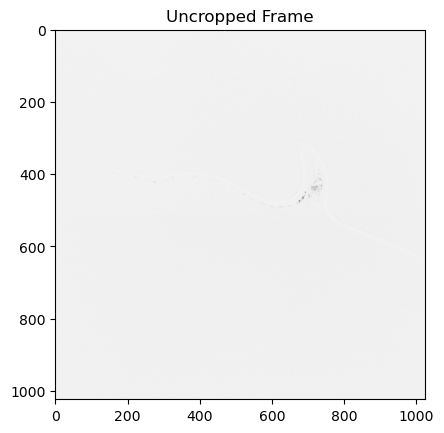

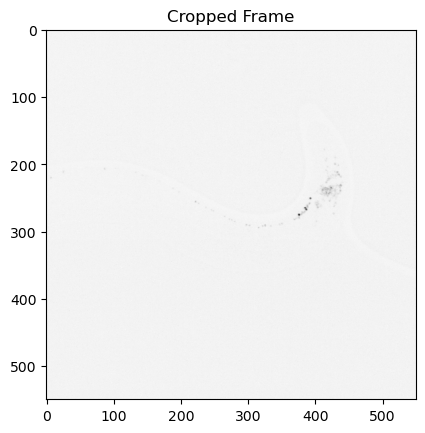

In [4]:
# Currently, we do the cropping visually. 
plt.imshow(uncropped_test_array[1,0], cmap = 'Greys')
plt.title("Uncropped Frame")
plt.show()

'''
by (my) inspection, y_min ~= 200, y_max ~= 750, x_min ~=300, x_max ~= 850
#someone else might inspect differently. If so, change the constants. It's good
#to crop first if possible to not waste time processing parts of the array that don't
matter
'''

Y_MIN = 200
Y_MAX = 750

X_MIN = 300
X_MAX = 850

test_array = uncropped_test_array[:, :, Y_MIN:Y_MAX, X_MIN:X_MAX]

#visualize again to double check 
plt.imshow(test_array[1,0], cmap = 'Greys')
plt.title("Cropped Frame")
plt.show()

# Aligning

## Visualizing shift and period

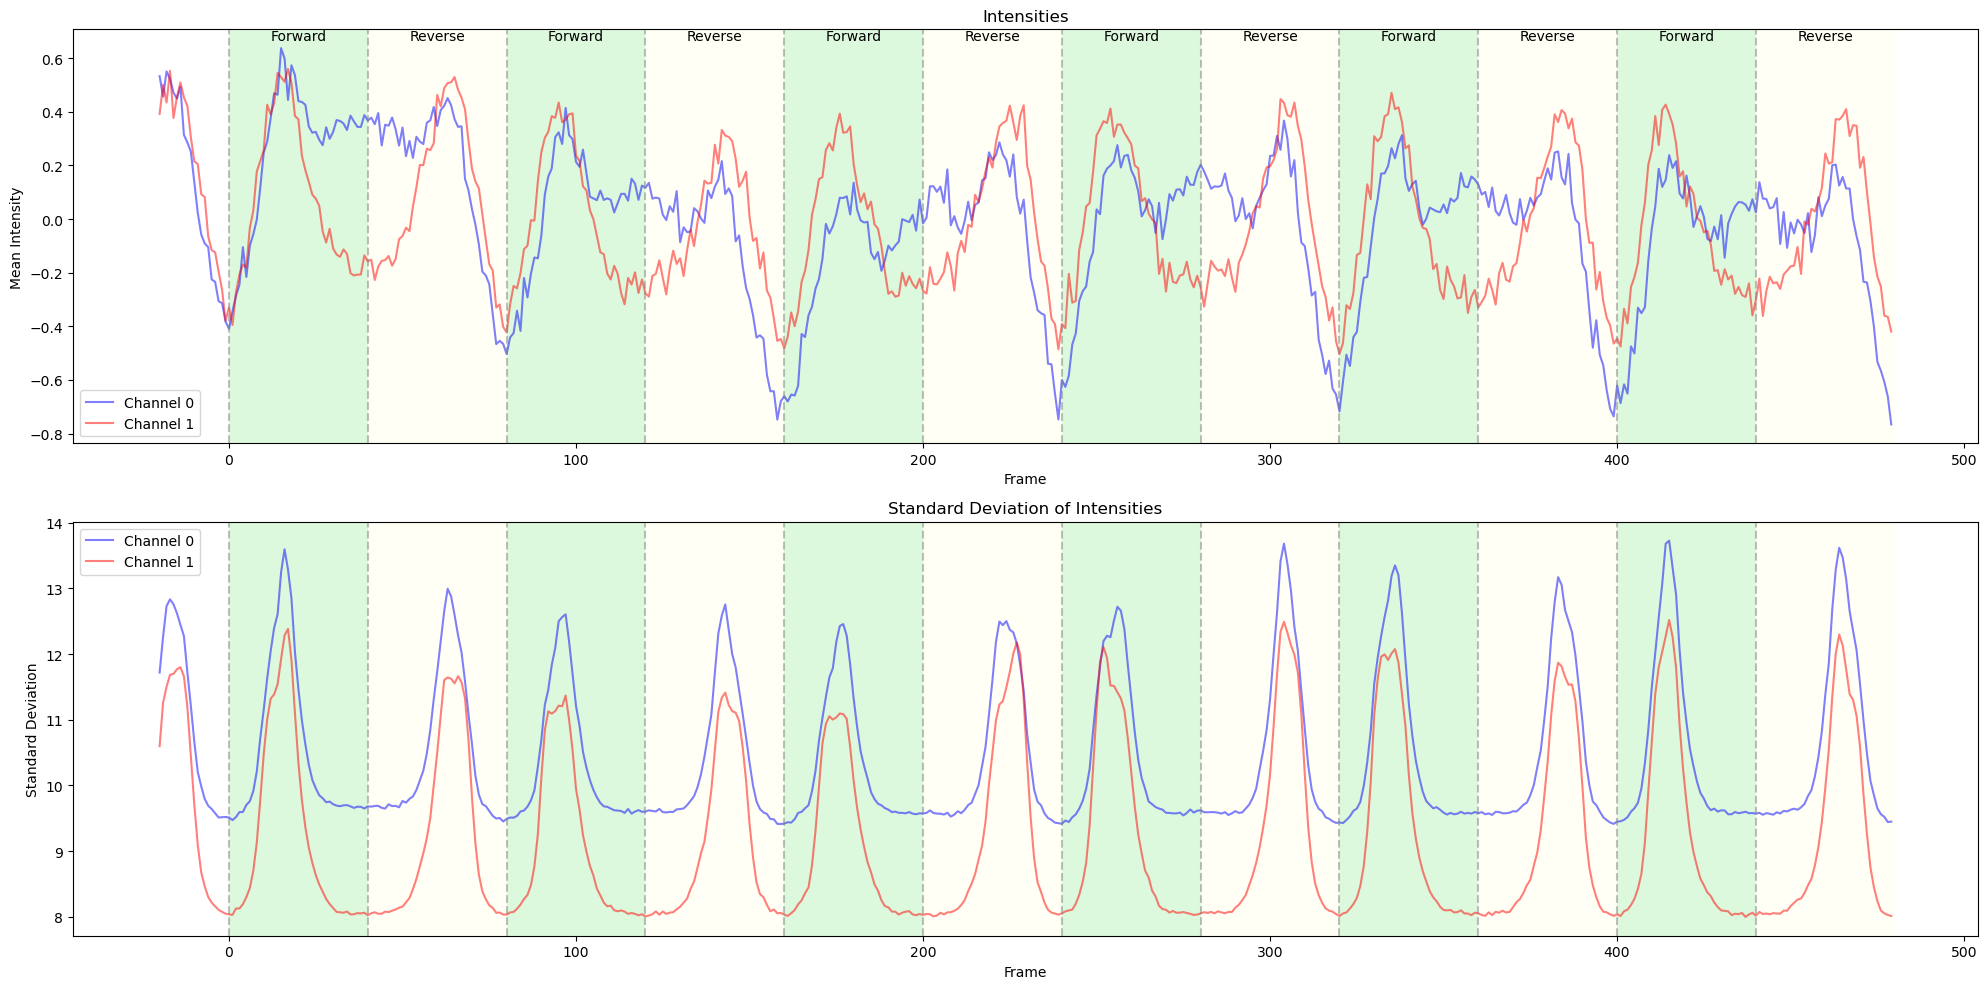

In [5]:
def plot_intensity_vs_frame(arr, start_idx=20, frames_per_volume=40, title = None):
    """
    Plot mean intensities and standard deviations of a 4D array (time, channel, height, width).
    
    Parameters:
    test_array (np.array): 4D array of shape (time, channel, height, width)
    start_idx (int): Starting index of the first volume
    frames_per_volume (int): Number of frames per volume
    """
    mean_intensities = np.mean(arr, axis=(2,3))
    std_intensities = np.std(arr, axis=(2,3))

    fig, axs = plt.subplots(2, 1, figsize=(20, 10), tight_layout=True)

    # Plot mean intensities
    ax = axs[0]
    ax.set_title('Intensities')
    ax.set_xlabel('Frame')
    ax.set_ylabel('Mean Intensity')
    
    xx = np.arange(-start_idx, arr.shape[0] - start_idx)


    ax.plot(xx, mean_intensities[:,0] - np.mean(mean_intensities[:,0]), label='Channel 0', color='blue', alpha=0.5)
    ax.plot(xx, mean_intensities[:,1] - np.mean(mean_intensities[:,1]), label='Channel 1', color='red', alpha=0.5)
    ax.legend()

    # Plot standard deviations
    axx = axs[1]
    axx.set_title('Standard Deviation of Intensities')
    axx.set_xlabel('Frame')
    axx.set_ylabel('Standard Deviation')
    axx.plot(xx, std_intensities[:,0], label='Channel 0', color='blue', alpha=0.5)
    axx.plot(xx, std_intensities[:,1], label='Channel 1', color='red', alpha=0.5)
    axx.legend()

    # Add colored rectangles to show alternating periods
    colors = ['lightgreen', 'lightyellow']
    for i in range(0, test_array.shape[0]-start_idx, frames_per_volume*2):
        for j, ax in enumerate(axs):
            ymin, ymax = ax.get_ylim()
            height = ymax - ymin
            # First period
            rect = Rectangle((i, ymin), frames_per_volume, height, facecolor=colors[0], alpha=0.3)
            ax.add_patch(rect)
            # Second period (reversed)
            rect = Rectangle((i+frames_per_volume, ymin), frames_per_volume, height, facecolor=colors[1], alpha=0.3)
            ax.add_patch(rect)
        
        # Add text to indicate direction
        axs[0].text(i+frames_per_volume/2, axs[0].get_ylim()[1], 'Forward', ha='center', va='top')
        axs[0].text(i+frames_per_volume*1.5, axs[0].get_ylim()[1], 'Reverse', ha='center', va='top')

    # Add vertical lines for volume boundaries
    for i in range(0, test_array.shape[0]-start_idx, frames_per_volume):
        for ax in axs:
            ax.axvline(x=i, color='gray', linestyle='--', alpha=0.5)

    if title:
        fig.suptitle(title, fontsize = 28)
    plt.show()


# Usage example:
# test_array should be a 4D numpy array of shape (time, channel, height, width)
plot_intensity_vs_frame(test_array)


## Reshaping the array to align

In [6]:
array = worm_array[:, :, Y_MIN:Y_MAX, X_MIN:X_MAX]

# COMMENT THIS OUT TO AVOID PROCESSING ENTIRE ARRAY IF STILL TESTING
# array = test_array 

START_IDX = 20
FPV = 40

D = FPV
num_frames = array.shape[0] - START_IDX
T = num_frames // FPV
C = 2
H = array.shape[2]
W = array.shape[3]

extra_frames = num_frames % FPV
if extra_frames > 0:
    tmp_arr = array[START_IDX:-extra_frames]
else:
    tmp_arr = array[START_IDX:]

# Reshape and transpose the array  
tmp_arr = tmp_arr.reshape(T, D, C, H, W).transpose(0, 2, 1, 3, 4)
#Finally align by flipping every other frame along the depth dimension
tmp_arr[1::2] = np.flip(tmp_arr[1::2], axis=2)
aligned_array = tmp_arr

print(f"    Aligned Array Shape: {aligned_array.shape} (T x C x D x H x W)")

##To double check, we can reverse the reshaping and transposing, and plot
##the full set of frames as we did above
## Reshape and transpose the array back

# tmp_arr = aligned_array.transpose(0, 2, 1, 3, 4).reshape(-1, C, H, W)
# plot_intensity_vs_frame(test_array, start_idx=20, frames_per_volume=40, title = 'Original Array')
# plot_intensity_vs_frame(tmp_arr, start_idx=0, frames_per_volume=40, title = 'Aligned Array')


    Aligned Array Shape: (124, 2, 40, 550, 550) (T x C x D x H x W)


# Filtering

Applying DoG filter: 100%|█████████████████████████████████████████████████████████████████████████████████████| 9920/9920 [01:28<00:00, 111.91it/s]


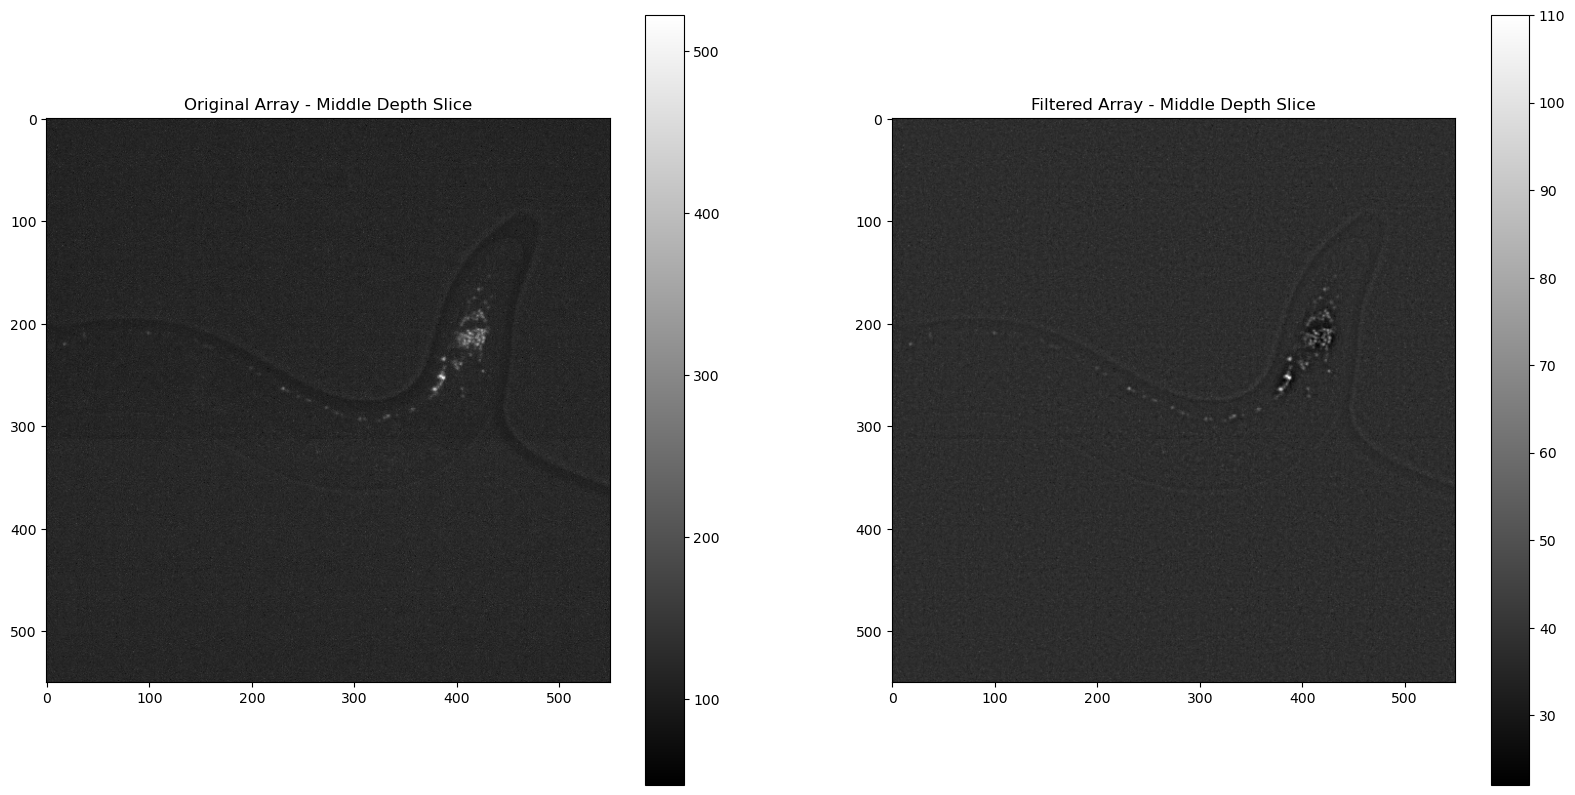

In [7]:
def dog_filter_2d(im, sigma1, sigma2):
    """Apply a difference of Gaussians filter"""
    im1 = gaussian_filter(im.astype(np.float32), sigma1)
    im2 = gaussian_filter(im.astype(np.float32), sigma2)
    return im1 - im2

# Ensure filtered_array is float32 or float64
filtered_array = np.zeros_like(aligned_array, dtype=np.float32)
total_iterations = T * C * D
sig1, sig2=0.5, 4

with tqdm(total=total_iterations, desc="Applying DoG filter") as pbar:
    for t in range(T):
        for c in range(C):
            for d in range(D):
                filtered_array[t, c, d] = dog_filter_2d(aligned_array[t, c, d], sig1, sig2)
                pbar.update(1)

# Normalize and scale the filtered array
filtered_array -= np.min(filtered_array)
filtered_array /= np.max(filtered_array)
filtered_array *= 255

# Convert to int8 after all floating-point operations are done
filtered_array = np.clip(filtered_array, 0, 255).astype(np.int8)
# Visualize the same frame from the filtered array
plt.figure(figsize=(20, 10))

# Plot original
plt.subplot(1, 2, 1)
plt.imshow(aligned_array[0, 0, D//2], cmap='gray')
plt.title('Original Array - Middle Depth Slice')
plt.colorbar()

# Plot filtered
plt.subplot(1, 2, 2) 
plt.imshow(filtered_array[0, 0, D//2], cmap='gray')
plt.title('Filtered Array - Middle Depth Slice')
plt.colorbar()

plt.show()



# Saving

In [8]:
# Define output path and file name
output_path = "./data/h5"
filename = '20241120_adult_1070'

# Ensure the output directory exists
os.makedirs(output_path, exist_ok=True)


N_neurons = 20 #so targettrack doesn't complain
# Save to HDF5 file
with h5py.File(os.path.join(output_path, filename+".h5"), 'w') as h5:
    # Save each time point
    for i in range(T):
        print(f"Saving time point {i}")
        dset = h5.create_dataset(f"{i}/frame", (C, W, H, D), dtype="i2", compression="gzip")
        dset[...] = np.transpose(filtered_array[i], (0, 2, 3, 1))  # Reorder dimensions to (C, W, H, D)
    
    # Set metadata attributes

    h5.attrs["name"] = filename
    h5.attrs["C"] = C
    h5.attrs["W"] = W
    h5.attrs["H"] = H
    h5.attrs["D"] = D
    h5.attrs["T"] = T
    h5.attrs["N_neurons"] = N_neurons

print("Finished saving the filtered array to HDF5 file.")


Saving time point 0
Saving time point 1
Saving time point 2
Saving time point 3
Saving time point 4
Saving time point 5
Saving time point 6
Saving time point 7
Saving time point 8
Saving time point 9
Saving time point 10
Saving time point 11
Saving time point 12
Saving time point 13
Saving time point 14
Saving time point 15
Saving time point 16
Saving time point 17
Saving time point 18
Saving time point 19
Saving time point 20
Saving time point 21
Saving time point 22
Saving time point 23
Saving time point 24
Saving time point 25
Saving time point 26
Saving time point 27
Saving time point 28
Saving time point 29
Saving time point 30
Saving time point 31
Saving time point 32
Saving time point 33
Saving time point 34
Saving time point 35
Saving time point 36
Saving time point 37
Saving time point 38
Saving time point 39
Saving time point 40
Saving time point 41
Saving time point 42
Saving time point 43
Saving time point 44
Saving time point 45
Saving time point 46
Saving time point 47
Sa